In [1]:
# Generate 1,000 samples to simulate a stationary AR(2) process

In [2]:
# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

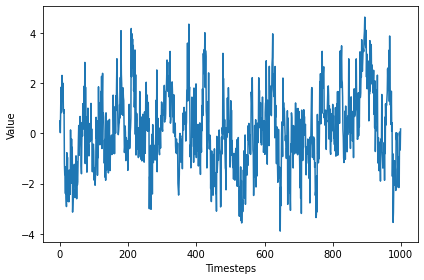

In [4]:
fig, ax = plt.subplots()

ax.plot(AR2_process)
ax.set_xlabel("Timesteps")
ax.set_ylabel("Value")

plt.tight_layout()

In [5]:
# Run the ADF test and check if the process is stationary
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(AR2_process)
print(f"ADF Statistic : {ADF_result[0]}")
print(f"P-Value : {ADF_result[1]}")

ADF Statistic : -7.566606021416912
P-Value : 2.9145161293761603e-11


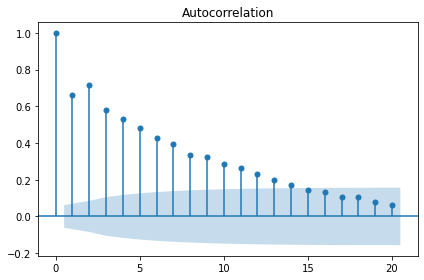

In [6]:
# The process is already stationery
# Plot the ACF to see if it is slowly decaying
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(AR2_process, lags=20)

plt.tight_layout()

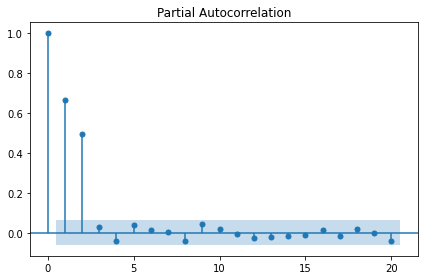

In [7]:
# Since it is slowly decaying, we do not have moving average process
# Plot the PACF to see if there are significant coefficients after 2 lags
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20)
plt.tight_layout()


In [8]:
# There is a suddden drop in significant coefficients after lag 2, so it is confirmed that we have a AR(2) process,
# Separate your simulated series into train and test sets. Take the first 800 timesteps for the train set 
# and assign the rest to the test set.

df = pd.DataFrame({'Value': AR2_process})

train = df[:800].copy()
test = df[800:].copy()

print(len(train))
print(len(test))

800
200


In [9]:
# Make forecasts over the test set. Use the historical mean method, last known value method, and an AR(2) model. 
# Use the rolling_forecast function, and use a window length of 2.

from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean
    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,0))      #The order specifies the AR(2) model
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR

In [10]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2                #Since we wish to predict the next 2 timesteps, our window is 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,Value,pred_mean,pred_last_value,pred_AR
800,1.153388,-0.049737,0.461912,0.208203
801,0.095529,-0.049737,0.461912,0.289199
802,0.704340,-0.048056,0.095529,0.586307
803,-0.182079,-0.048056,0.095529,0.233598
804,-0.142412,-0.047287,-0.182079,0.281393


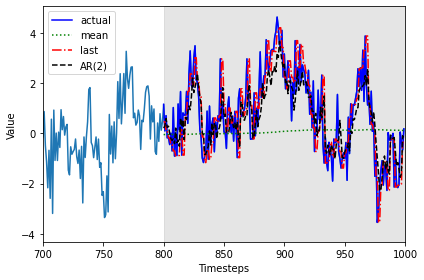

In [11]:
fig, ax = plt.subplots()

ax.plot(df['Value'])
ax.plot(test['Value'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(2)')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

ax.set_xlim(700, 1000)
plt.tight_layout()

In [12]:
# Measure the MSE, and identify your champion model
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['Value'], test['pred_mean'])
mse_last = mean_squared_error(test['Value'], test['pred_last_value'])
mse_AR = mean_squared_error(test['Value'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.0882016808214443 1.2111519051869672 0.9692635186306567


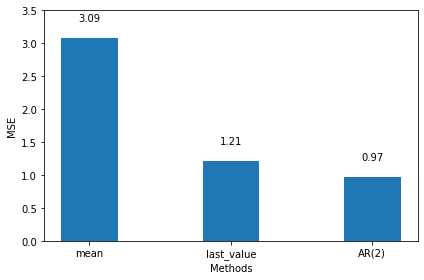

In [13]:
# Plot your MSEs in a bar plot

fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(2)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 3.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')
    
plt.tight_layout()

In [14]:
# record end time

end = dt.now()
elapsed = end-start
print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:00:40
